In [13]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation

import operator
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [51]:
# (1) read in data
print("Load the training, test and store data using pandas")
types = {'StateHoliday': np.dtype(str),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str),
         'Assortment': np.dtype(str), 
         'PromoInterval': np.dtype(str),
         'StoreType': np.dtype(str)
        }


train_df = pd.read_csv("../data/train.csv", dtype=types)
store_df = pd.read_csv("../data/store.csv", dtype=types, keep_default_na=False, na_values= '')
test_df = pd.read_csv("../data/test.csv", dtype=types)

Load the training, test and store data using pandas


In [28]:
# (2) show data feature
train_df[0:10]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


In [66]:
def dummy_object(df, Object_List):
    for x in Object_List:
        df[x].fillna("Missing", inplace=True) # Missing is also maybe a option for categorize
        dummies = pd.get_dummies(df[x], prefix=x, prefix_sep="dummy") # create dummies array
        #print(list(dummies.dtypes.index))
        df2 = pd.concat([df, dummies], axis=1) # put together
        df2.drop([x],axis=1, inplace=True)
        #print(list(df.dtypes.index))
    return df2

In [71]:
print(dummy_object(store_df,['Assortment', 'StoreType']).dtypes.index)
print("---------------------")
store_df= dummy_object(store_df,['Assortment', 'StoreType'])
print(store_df.dtypes.index)

Index(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Assortmentdummya',
       'Assortmentdummyb', 'Assortmentdummyc', 'StoreTypedummya',
       'StoreTypedummyb', 'StoreTypedummyc', 'StoreTypedummyd'],
      dtype='object')
---------------------
Index(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Assortmentdummya',
       'Assortmentdummyb', 'Assortmentdummyc', 'StoreTypedummya',
       'StoreTypedummyb', 'StoreTypedummyc', 'StoreTypedummyd'],
      dtype='object')


In [72]:
store_df[0:10]

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Assortmentdummya,Assortmentdummyb,Assortmentdummyc,StoreTypedummya,StoreTypedummyb,StoreTypedummyc,StoreTypedummyd
0,1,1270,9,2008,0,NaN,NaN,NaN,1,0,0,0,0,1,0
1,2,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",1,0,0,1,0,0,0
2,3,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",1,0,0,1,0,0,0
3,4,620,9,2009,0,NaN,NaN,NaN,0,0,1,0,0,1,0
4,5,29910,4,2015,0,NaN,NaN,NaN,1,0,0,1,0,0,0
5,6,310,12,2013,0,NaN,NaN,NaN,1,0,0,1,0,0,0
6,7,24000,4,2013,0,NaN,NaN,NaN,0,0,1,1,0,0,0
7,8,7520,10,2014,0,NaN,NaN,NaN,1,0,0,1,0,0,0
8,9,2030,8,2000,0,NaN,NaN,NaN,0,0,1,1,0,0,0
9,10,3160,9,2009,0,NaN,NaN,NaN,1,0,0,1,0,0,0


In [30]:
print("\n"+"----train-------")
train_df.info()
print("\n"+"----store----------")
store_df.info()
print("\n"+"----test----------")
test_df.info()


----train-------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null float64
dtypes: float64(1), int64(6), object(2)
memory usage: 77.6+ MB

----store----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2         

In [31]:
def describe_object(X):
    # return object variables only
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))
    
def show_object(X):
    category=np.unique(list(X.select_dtypes(['object'])))
    print("------------------Categorical Columns---------------------")
    print(category)
    print("\n")
    print("------------List all----------------------")
    for column in category:
        {
        print(column + ':' + str(np.unique(list(X[column])))+'\n')
        }

def show_object_No(X, No):
    category=np.unique(list(filter(lambda x: x!= No, X.select_dtypes(['object']))))
    print("----------Categorical Columns------remove-"+No+"--------------")
    print(category)
    print("\n")
    print("------------List all----------------------")
    for column in category:
        {
        print(column + ':' + str(np.unique(list(X[column])))+'\n')
        }
        
def show_object_NoList(X, NoList):
    category=np.unique(list(filter(lambda x: (x not in NoList), X.select_dtypes(['object']))))
    print("----------Categorical Columns---remove----"+', '.join(NoList)+"--------------")
    print(category)
    print("\n")
    print("------------List all----------------------")
    for column in category:
        {
        print(column + ':' + str(np.unique(list(X[column])))+'\n')
        }

In [32]:
describe_object(train_df)
show_object_No(train_df,'Date')
print("--------------------------")
describe_object(store_df)
show_object(store_df)

,Date,StateHoliday
count,1017209,1017209
unique,942,4
top,2015-05-17,0
freq,1115,986159


----------Categorical Columns------remove-Date--------------
['StateHoliday']


------------List all----------------------
StateHoliday:['0' 'a' 'b' 'c']

--------------------------


,StoreType,Assortment,PromoInterval
count,1115,1115,571
unique,4,3,3
top,a,a,"Jan,Apr,Jul,Oct"
freq,602,593,335


------------------Categorical Columns---------------------
['Assortment' 'PromoInterval' 'StoreType']


------------List all----------------------
Assortment:['a' 'b' 'c']

PromoInterval:['Feb,May,Aug,Nov' 'Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec' 'nan']

StoreType:['a' 'b' 'c' 'd']



In [33]:
# features_build: features List;  data (data frame in -> data frame out)
def features_build(features, data):
    # fill nan with 0
    data.fillna(0, inplace=True)
    #data.loc[data.open.isnull(), 'Open'] =1
    #features as a list to store reference columns for training
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])
    
    # add columns (features list and then data import)
    #(1) categorical to 12345 mapping
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'a':1, 'b':2, 'c':3, 'd':4, '0':0}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #(2) Date 
    features.extend(['DayofWeek', 'Month', 'Day', 'Year', 'WeekofYear'])
    data['Year'] = pd.to_datetime(data.Date).dt.year
    data['Month'] = pd.to_datetime(data.Date).dt.month
    data['Day'] = pd.to_datetime(data.Date).dt.day
    data['DayofWeek'] = pd.to_datetime(data.Date).dt.dayofweek
    data['WeekofYear'] = pd.to_datetime(data.Date).dt.weekofyear
    
    #(3) Other time
    features.extend(['CompetitionOpenMonth'])
    data['CompetitionOpenMonth'] = (data.Month - data.CompetitionOpenSinceMonth) + 12 * (data.Year - data.CompetitionOpenSinceYear)
    
    features.extend(['Promo2SinceMonth'])
    data['Promo2SinceMonth'] = (data.WeekofYear - data.Promo2SinceWeek)/4 + 12 * (data.Year - data.Promo2SinceYear)
    data['Promo2SinceMonth'] = data.Promo2SinceMonth.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'Promo2SinceMonth'] = 0
    
    
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
                
    return data



In [34]:
##

In [35]:
print("Assume store open, if not provided")
test_df.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train_df = train_df[train_df["Open"] != 0]
print("Use only Sales bigger then zero")
train_df = train_df[train_df["Sales"] > 0]

print("Join with store")
train_df = pd.merge(train_df, store_df, on='Store')
test_df = pd.merge(test_df, store_df, on='Store')

Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero
Join with store


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 18 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null object
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null float64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          842152 non-null float64
CompetitionOpenSinceMonth    575738 non-null float64
CompetitionOpenSinceYear     575738 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              421046 non-null float64
Promo2SinceYear              421046 non-null float64
PromoI

In [37]:
features = []

print("augment features")
train_df = features_build(features, train_df)
print(features)
test_df = features_build([], test_df)


print('training data processed')

def rmspe(y, yhat):
    return np.sqrt(np.mean(((y - yhat)/y) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

print("Train xgboost model")

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.85,
          "colsample_bytree": 0.4,
          "min_child_weight": 6,
          "silent": 1,
          "thread": 1,
          "seed": 1301
          }
num_boost_round = 100

augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayofWeek', 'Month', 'Day', 'Year', 'WeekofYear', 'CompetitionOpenMonth', 'Promo2SinceMonth', 'IsPromoMonth']
training data processed
Train xgboost model


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 27 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null object
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null int64
SchoolHoliday                844338 non-null float64
StoreType                    844338 non-null int64
Assortment                   844338 non-null int64
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
Promo2SinceYear              844338 non-null float64
PromoInte

In [39]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,DayofWeek,WeekofYear,CompetitionOpenMonth,Promo2SinceMonth,IsPromoMonth
count,844338.000000,844338.000000,844338.000000,844338.000000,844338,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,...,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,558.421374,3.520350,6955.959134,762.777166,1,0.446356,0.001418,0.193578,2.205441,1.936493,...,11.596159,1003.201259,2013.831945,5.845774,15.835706,2.520350,23.646946,7730.589779,13.053234,0.171984
std,321.730861,1.723712,3103.815515,401.194153,0,0.497114,0.047578,0.395102,1.363375,0.993099,...,15.308101,1005.874685,0.777271,3.323959,8.683392,1.723712,14.389931,11230.049970,18.973591,0.377367
min,1.000000,1.000000,46.000000,8.000000,1,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,2013.000000,1.000000,1.000000,0.000000,1.000000,-31.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,1,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,2013.000000,3.000000,8.000000,1.000000,11.000000,29.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,1,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,2014.000000,6.000000,16.000000,2.000000,23.000000,91.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1,1.000000,0.000000,0.000000,4.000000,3.000000,...,22.000000,2012.000000,2014.000000,8.000000,23.000000,4.000000,35.000000,24163.000000,25.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1,1.000000,3.000000,1.000000,4.000000,3.000000,...,50.000000,2015.000000,2015.000000,12.000000,31.000000,6.000000,52.000000,24187.000000,72.000000,1.000000


In [40]:
print("Train a XGBoost model")
X_train, X_valid = train_test_split(train_df, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)


Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.999526	eval-rmspe:0.999525
[1]	train-rmspe:0.998816	eval-rmspe:0.998814
[2]	train-rmspe:0.997531	eval-rmspe:0.997528
[3]	train-rmspe:0.995362	eval-rmspe:0.995358
[4]	train-rmspe:0.991917	eval-rmspe:0.991911
[5]	train-rmspe:0.986768	eval-rmspe:0.986762
[6]	train-rmspe:0.979481	eval-rmspe:0.979477
[7]	train-rmspe:0.969542	eval-rmspe:0.969542
[8]	train-rmspe:0.956673	eval-rmspe:0.956684
[9]	train-rmspe:0.940462	eval-rmspe:0.940467
[10]	train-rmspe:0.920775	eval-rmspe:0.920770
[11]	train-rmspe:0.897729	eval-rmspe:0.897702
[12]	train-rmspe:0.871382	eval-rmspe:0.871330
[13]	train-rmspe:0.841935	eval-rmspe:0.841835
[14]	train-rmspe:0.810010	eval-rmspe:0.809845
[15]	train-rmspe:0.775877	eval-rmspe:0.775554
[16]	train-rmspe:0.740331	eval-rmspe:0.739765
[17]	train-rmspe:0.703862	eval-rmspe:0.702976
[18]	train-rmspe:0.667011	eval-rmspe:0.665741
[19]	train-rmspe:0.630487	eval-rmspe:0.628709
[20]	train-rmspe:0.594718	eval

Train a XGBoost model


[99]	train-rmspe:0.249915	eval-rmspe:0.206444


In [41]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
dtest = xgb.DMatrix(test_df[features])
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test_df["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_10_submission.csv", index=False)

Validating
RMSPE: 0.206444
Make predictions on the test set


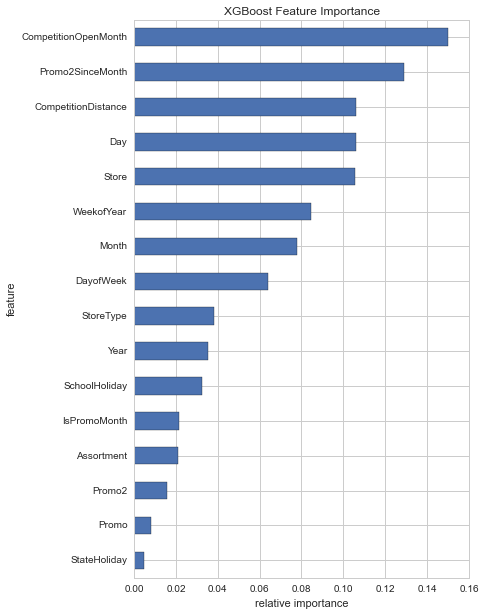

In [42]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
import matplotlib.pyplot as plt
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)


In [48]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Year,Month,Day,DayofWeek,WeekofYear,CompetitionOpenMonth,Promo2SinceMonth,monthStr,IsPromoMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,3,...,,2015,7,31,4,31,82,0,Jul,0
1,1,4,2015-07-30,5020,546,1,1,0,1,3,...,,2015,7,30,3,31,82,0,Jul,0
2,1,3,2015-07-29,4782,523,1,1,0,1,3,...,,2015,7,29,2,31,82,0,Jul,0
3,1,2,2015-07-28,5011,560,1,1,0,1,3,...,,2015,7,28,1,31,82,0,Jul,0
4,1,1,2015-07-27,6102,612,1,1,0,1,3,...,,2015,7,27,0,31,82,0,Jul,0
